In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import seaborn as sns

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import theano as th
print('theano version: ', th.__version__)

import warnings
warnings.filterwarnings('ignore')


from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import os
import random

('python version: ', '2.7.15 |Anaconda, Inc.| (default, Dec 14 2018, 19:04:19) \n[GCC 7.3.0]')
('pandas version: ', u'0.23.4')
('numpy version: ', '1.15.4')
('scipy version: ', '1.1.0')
('sklearn version: ', '0.19.2')


Using TensorFlow backend.


('keras version: ', '2.1.6')
('keras backend: ', u'tensorflow')
('tensorflow version: ', '1.10.0')
('theano version: ', '0.8.2')


In [2]:
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

In [3]:
excel_file = r'geriomop-data-from-egems-paper-UPDATED-COL-FIX-ATC_2-and-behavior-change-022819.tsv'
df = pd.DataFrame(pd.read_csv(excel_file, sep='\t'))
print(df.shape)

(7584, 208)


In [4]:
# Get atc codes
atc_list = []
for i in range(1, 6):
    atc_list.append(df.groupby('atc_%d' % i)['min_effective_dose_%d' % i].first())
atc_codes = pd.concat(atc_list)
atc_codes = atc_codes[~atc_codes.index.duplicated()].index.tolist()

# Fill missing min_effective_dose
atc_dic = [('N03AE01', 0.5), ('N05AB04', 15), ('N05AX13', 3), ('N05CD04', 1), ('N06AX21', 60), ('N06AX24', 20), \
           ('N06AX23', 50)]
for code, dose in atc_dic:
    for i in range(1, 6):
        df.loc[df['atc_%d' % i] == code, 'psych_sdd_%d' % i] = \
            df.loc[df['atc_%d' % i] == code, 'Psychotropic-%d-average-daily-dose' % i] / dose

# Set sdd=0 to NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan

In [5]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)

In [6]:
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

In [7]:
# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

In [8]:
# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)

In [9]:
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)

In [10]:
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
            mmin = df_ref[col].max()
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [11]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = GroupShuffleSplit(train_size=radio, random_state=random_state).split(df, target, df[groupby]).next()
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [12]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

In [13]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "mds-delirium-scale", "mds-long-term-memory-ok", "mds-short-term-memory-ok", "mds-staff-assess-pain", \
             "recent-start-other-fall-risk-rx"] + ["mds-pressure-ulcer-stage-%d" % i for i in range(1, 5)]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']] * 9

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [14]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["cms-long-stay", "mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-dehydrated", "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other", "ws-antibiotic-anticoag-coexposure", \
            "ws-psychotropic-with-not-ordered-weight-loss", \
            "ws-diuretic-adl", "ws-tramadol-antidepressant-coexposure"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 28 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "facility", "gender", "mds-bims-summary-ranking", "ws-meclizine-psych-coexposure"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Sugar Creek', 'Heritage Place', 'Canterbury Place', 'Senaca Place', 'Cranberry Place'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment'], \
                 ['No', 'meclAndPsychStartSameR', 'meclPrecedesPsychR', 'psychPrecedesMeclR', 'meclAndPsychOlderStart']]

In [15]:
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)] + ["Psychotropic-%d-average-daily-dose" % i for i in range(1, 6)]

In [16]:
# generate target
target = df['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
print 'Total number of patients: %d' % len(df.groupby('patient-id'))
print 'Number of patients in training set: %d' % len(X_train.groupby('patient-id'))

Total number of patients: 3133
Number of patients in training set: 2193


In [18]:
%%time
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 11.7 s, sys: 136 ms, total: 11.8 s
Wall time: 10.1 s


In [19]:
X_train_use = X_train.copy()

In [20]:
X_train.dtypes[X_train.dtypes == 'object'].index

Index([u'marital-status', u'mds-entered-from', u'mds-pain-medication',
       u'mds-received-pain-tx-non-pharm', u'mds-received-prn-pain-medication',
       u'mds-excess-weight-loss', u'mds-urinary-incontinence', u'pneumonia',
       u'uti', u'mdro', u'anemia', u'septicemia', u'constipation', u'wound',
       u'hyponatremia', u'hyperkalemia', u'embolisms', u'alzheimers',
       u'anxiety', u'depression', u'non-alz-dimentia', u'bipolar',
       u'parkinsons', u'psychosis', u'schizophrenia', u'seizure', u'aphasia',
       u'emphysema', u'arthritis', u'ashd', u'bph', u'cancer',
       u'cerebralpalsy', u'stroke', u'cirrhosis', u'comatose', u'diabetes',
       u'dysrhythmias', u'gerd', u'heart-failure', u'hemiplegia/hemiparesis',
       u'hepatitis', u'huntingtons', u'hyperlipidemia', u'hyperthyroidism',
       u'hypothyroidism', u'hypertension', u'hypotension',
       u'multiple-sclerosis', u'neurogenic-bladder', u'obstructive-uropathy',
       u'osteoporosis', u'paraplegia', u'ptsd', u'p

In [36]:
# missing_summary(X_train_use)

In [22]:
%%time
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 8.49 s, sys: 0 ns, total: 8.49 s
Wall time: 8.49 s


In [23]:
X_test_use = X_test.copy()

In [24]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([u'marital-status', u'mds-entered-from', u'mds-pain-medication',
       u'mds-received-pain-tx-non-pharm', u'mds-received-prn-pain-medication',
       u'mds-excess-weight-loss', u'mds-urinary-incontinence', u'pneumonia',
       u'uti', u'mdro', u'anemia', u'septicemia', u'constipation', u'wound',
       u'hyponatremia', u'hyperkalemia', u'embolisms', u'alzheimers',
       u'anxiety', u'depression', u'non-alz-dimentia', u'bipolar',
       u'parkinsons', u'psychosis', u'schizophrenia', u'seizure', u'aphasia',
       u'emphysema', u'arthritis', u'ashd', u'bph', u'cancer',
       u'cerebralpalsy', u'stroke', u'cirrhosis', u'comatose', u'diabetes',
       u'dysrhythmias', u'gerd', u'heart-failure', u'hemiplegia/hemiparesis',
       u'hepatitis', u'huntingtons', u'hyperlipidemia', u'hyperthyroidism',
       u'hypothyroidism', u'hypertension', u'hypotension',
       u'multiple-sclerosis', u'neurogenic-bladder', u'obstructive-uropathy',
       u'osteoporosis', u'paraplegia', u'ptsd', u'p

In [37]:
# missing_summary(X_test_use)

In [26]:
X_train_use.shape

(5311, 194)

In [27]:
X_test_use.shape

(1512, 194)

In [28]:
idx = missing_summary(X_train_use).index.tolist()
X_train_use.drop(columns=idx, axis=1, inplace=True)
X_test_use.drop(columns=idx, axis=1, inplace=True)

In [29]:
X_train_use.shape

(5311, 100)

In [30]:
X_test_use.shape

(1512, 100)

### Use Sklearn MInMaxScaler to do feature scaling.

In [31]:
# drop patient ID for basic models

from sklearn.preprocessing import MinMaxScaler

def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
#     X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
#     X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [32]:
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

### ALl 99 features are non-missing variables.

In [33]:
X_train_transformed.shape

(5311, 99)

# Basic Model Experiment: Use non-missing values to train model
### Prepare Test Set Features


In [34]:
from sklearn import preprocessing ## for standarScaler
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.core.frame import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor,RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.cross_validation import *
from sklearn.svm import LinearSVC
from sklearn.learning_curve import validation_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
# from sklearn.svm import SVC

In [35]:
def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

In [36]:
# def find_best_recall(y_predict, y_true):
#     fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
#     max_recall, th = 0, 0
#     for threshold in thresholds:
#         recall = recall_score(y_true, y_predict > threshold)
#         if(recall > max_recall):
#             max_recall = recall
#             th = threshold
#     return max_recall, th

### metrics_m_prob and metrics_m_pre funcations  are all functions to return metrics and thresholds with best F1 after tuning hyper-parameters for basic models based on optimizing AUROC. metrics_m_pre function is prepared in case of some models and associated hyper-paratemers can't generate results in probabilities format in different classes.

In [43]:
def metrics_m_prob (model,X_train_transformed,X_test_transformed,y_train,y_test):
    Model = model.fit(X_train_transformed, y_train)
    prediction=Model.predict(X_test_transformed)
    accuracy=accuracy_score(y_test,prediction)
    precision=precision_score(y_test, prediction) # get precision score
    recall=recall_score(y_test, prediction) # get recall score
    F1=f1_score(y_test, prediction) # get F1 score

    tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
    specificity=float(tn) / (tn+fp) # get specificity score
    prediction_prob=Model.predict_proba(X_test_transformed)
    prediction_prob=prediction_prob[:,1]
    fpr, tpr, tresholds = roc_curve(y_test, prediction_prob)
    roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score

    dic_=  dict([('accuracy', accuracy), ('precision', precision), ('recall', recall),('F1',F1),('specificity', specificity),('AUROC', roc_auc)])
    dic_df=pd.DataFrame(pd.Series(dic_),columns=['Score'])
    dic_df=dic_df.reset_index().rename(columns={'index':'metrics'})
    
    
    
    f1, th = find_best_f1(prediction_prob, y_test)

    ## maximum F1
    y_threshold = prediction_prob > th
    tn, fp, fn, tp = confusion_matrix(y_test, y_threshold).ravel()

    
    dic_f1= dict([('accuracy', accuracy_score(y_test, y_threshold)), ('precision', precision_score(y_test, y_threshold)), ('recall', recall_score(y_test, y_threshold)),('F1',f1_score(y_test, y_threshold)),('specificity', (float(tn) / (tn+fp)))])
    dic_df_f1=pd.DataFrame(pd.Series(dic_f1),columns=['Score'])
    dic_df_f1=dic_df_f1.reset_index().rename(columns={'index':'metrics'})
   
    return dic_df,dic_df_f1,th


In [44]:
def metrics_m_pre (model,X_train_transformed,X_test_transformed,y_train,y_test):
    Model = model.fit(X_train_transformed, y_train)
    prediction=Model.predict(X_test_transformed)
    accuracy=accuracy_score(y_test,prediction)
    precision=precision_score(y_test, prediction) # get precision score
    recall=recall_score(y_test, prediction) # get recall score
    F1=f1_score(y_test, prediction) # get F1 score

    tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
    specificity=float(tn) / (tn+fp) # get specificity score
#     prediction_prob=Model.predict_proba(X_test_transformed)
#     prediction_prob=prediction_prob[:,1]
    fpr, tpr, tresholds = roc_curve(y_test, prediction)
    roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score

    dic_=  dict([('accuracy', accuracy), ('precision', precision), ('recall', recall),('F1',F1),('specificity', specificity),('AUROC', roc_auc)])
    dic_df=pd.DataFrame(pd.Series(dic_),columns=['Score'])
    dic_df=dic_df.reset_index().rename(columns={'index':'metrics'})
    
    
    
    f1, th = find_best_f1(prediction, y_test)

    ## maximum F1
    y_threshold = prediction> th
    tn, fp, fn, tp = confusion_matrix(y_test, y_threshold).ravel()

    
    dic_f1= dict([('accuracy', accuracy_score(y_test, y_threshold)), ('precision', precision_score(y_test, y_threshold)), ('recall', recall_score(y_test, y_threshold)),('F1',f1_score(y_test, y_threshold)),('specificity', (float(tn) / (tn+fp)))])
    dic_df_f1=pd.DataFrame(pd.Series(dic_f1),columns=['Score'])
    dic_df_f1=dic_df_f1.reset_index().rename(columns={'index':'metrics'})
   
    return dic_df,dic_df_f1,th


### AUROC_Tain_prob and AUROC_Tain_pre functions can generate AUROC  scores of training set. UROC_Tain_pre is prepared in case of some models and associated hyper-paratemers can't generate results in probabilities format in different classes.¶

In [39]:
def AUROC_Tain_prob(model,X_train_transformed,y_train):
    # training set
    Model = model.fit(X_train_transformed, y_train)
    # prediction=Model.predict(X_train_transformed)
    prediction_prob=Model.predict_proba(X_train_transformed)
    prediction_prob=prediction_prob[:,1]


    fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
    roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
    return roc_auc

In [40]:
def AUROC_Tain_pre(model,X_train_transformed,y_train):
    # training set
    Model = model.fit(X_train_transformed, y_train)
    prediction=Model.predict(X_train_transformed)
#     prediction_prob=Model.predict_proba(X_train_transformed)
#     prediction_prob=prediction_prob[:,1]


    fpr, tpr, tresholds = roc_curve(y_train, prediction)
    roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
    return roc_auc

In [69]:
def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def drawAUROC (model,figureName):
    Model = model.fit(X_train_transformed, y_train)
    prediction_prob=Model.predict_proba(X_test_transformed)
    prediction_prob=prediction_prob[:,1]
    fpr, tpr, tresholds = roc_curve(y_test, prediction_prob)

    f1, th = find_best_f1(prediction_prob, y_test)
    y_threshold = prediction_prob > th
    tn, fp, fn, tp = confusion_matrix(y_test, y_threshold).ravel()
    recall=recall_score(y_test, y_threshold)
    specificity=(float(tn) / (tn+fp))


    import csv 
    fpr, tpr, thresholds = roc_curve(y_test, prediction_prob, pos_label=1)
    plot_roc_curve(fpr, tpr)
    with open(figureName, "w") as writeFile:
        writer  = csv.writer(writeFile)
        writer.writerows([fpr, tpr, [recall, 1-specificity]])

In [83]:
from sklearn.calibration import calibration_curve
import csv 

def calibPlots (model,figureName):
    Model = model.fit(X_train_transformed, y_train)
    prediction_prob=Model.predict_proba(X_test_transformed)
    prediction_prob=prediction_prob[:,1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prediction_prob, n_bins=10)
    with open(figureName, "w") as writeFile:
        writer  = csv.writer(writeFile)
        writer.writerows([fraction_of_positives, mean_predicted_value])

    plt.figure()
    plt.plot(mean_predicted_value, fraction_of_positives, 's-')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.show()


In [90]:
from sklearn.calibration import calibration_curve
import csv 

def calibPlots_normalized (model,figureName):
    Model = model.fit(X_train_transformed, y_train)
    prediction_prob=Model.predict_proba(X_test_transformed)
    prediction_prob=prediction_prob[:,1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prediction_prob, normalize=True, n_bins=10)
    with open(figureName, "w") as writeFile:
        writer  = csv.writer(writeFile)
        writer.writerows([fraction_of_positives, mean_predicted_value])

    plt.figure()
    plt.plot(mean_predicted_value, fraction_of_positives, 's-')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.show()

# tuning hyperparameters for Logistic regression based on "roc_auc"

### For the Logistic regression model, there are two penalty choices, including l1 and l2. However, some solver are not applicable to bother of them, so I separate them in the tuning procedure. After runing for several time,'l2' is more suitable for LR in strategy 1. Thus, we just leave the cell getting current best tuning results.

In [39]:
parameters={'C':[0.25,0.5, 0.75, 1,1.5], 'solver':('liblinear','sag','newton-cg', 'lbfgs')}
model = LogisticRegression(penalty='l2',class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters, n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'C': 0.25, 'solver': 'liblinear'}
             precision    recall  f1-score   support

          0       0.87      0.75      0.80      1229
          1       0.32      0.51      0.39       283

avg / total       0.77      0.70      0.73      1512



In [104]:
clf_model=LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [105]:
results[0] ## this returns metrics with default threshold (0.5) for all metrics

,metrics,Score
0,AUROC,0.689233
1,F1,0.392954
2,accuracy,0.703704
3,precision,0.318681
4,recall,0.512367
5,specificity,0.747762


In [106]:
results[1] ## this returns metrics with best F1 threshold, the AUROC is same as the above

,metrics,Score
0,F1,0.408889
1,accuracy,0.648148
2,precision,0.298217
3,recall,0.650177
4,specificity,0.647681


In [107]:
results[2]  ## this returns the threshold with best F1 

0.44564964869857704

In [41]:
clf_model=LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100)
# training set
AUROC_Tain_prob (clf_model,X_train_transformed,y_train)  ## return the training set AUROC score

0.7187593948944633

### LR AUROC cureve 

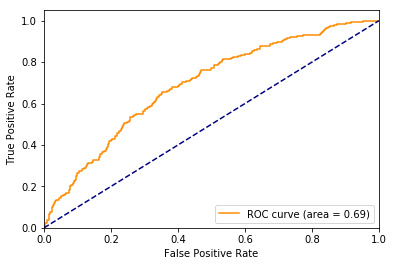

In [73]:
model=LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100) # LR
drawAUROC(model,'LR_exp_1.csv')

### LR calibration plots without normalzied

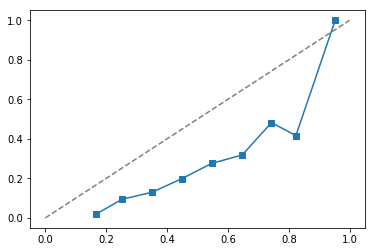

In [86]:
model=LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100)
calibPlots(model,'LR_exp_1_cal.csv')

### LR calibration plots with normalzied

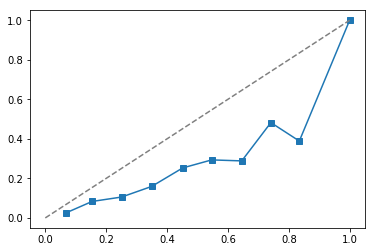

In [91]:
model=LogisticRegression(penalty='l2',class_weight='balanced',C=0.25, solver='liblinear',random_state=100)
calibPlots_normalized(model,'LR_exp_1_NorCal.csv')

# tuning hyperparameters for randomForest Tree based on "roc_auc"¶

### RF using less aggressive hyper-parameters when there is less risk of overfitting

In [57]:
parameters={'criterion':('gini','entropy'),'n_estimators':range(11,201,10),'max_depth':range(1,11,2), 'max_leaf_nodes':range(5,30,5)}
model = RandomForestClassifier(class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters,n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'n_estimators': 121, 'max_leaf_nodes': 20, 'criterion': 'gini', 'max_depth': 7}
             precision    recall  f1-score   support

          0       0.86      0.75      0.80      1229
          1       0.31      0.49      0.38       283

avg / total       0.76      0.70      0.72      1512



In [63]:
clf_model=RandomForestClassifier(class_weight='balanced',n_estimators=121,max_leaf_nodes=20,criterion='gini',max_depth=7,random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [64]:
results[0]   ## this returns metrics with default threshold (0.5) for all metrics

,metrics,Score
0,AUROC,0.684191
1,F1,0.376535
2,accuracy,0.697751
3,precision,0.306667
4,recall,0.487633
5,specificity,0.746135


In [65]:
results[1]   ## this returns metrics with best F1 threshold, the AUROC is same as the above

,metrics,Score
0,F1,0.393162
1,accuracy,0.624339
2,precision,0.281776
3,recall,0.650177
4,specificity,0.618389


In [61]:
results[2]   ## this returns the threshold with best F1

0.47281621262030893

In [62]:
clf_model=RandomForestClassifier(class_weight='balanced',n_estimators=121,max_leaf_nodes=20,criterion='entropy',max_depth=7,random_state=100)
# training set
AUROC_Tain_prob (clf_model,X_train_transformed,y_train)  ## return the training set AUROC score

0.7573156878042058

In [ ]:
#########################

In [ ]:
#########################

### RF using aggressive hyper-parameters with final results shown in AMIA paper

In [40]:
parameters={'criterion':('gini','entropy'),'n_estimators':[200,500,800,1000,1500,2000],'max_depth':[10,20,30,50,80], 'max_leaf_nodes':[5,50,100,150,180]}
model = RandomForestClassifier(class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters,n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'n_estimators': 500, 'max_leaf_nodes': 50, 'criterion': 'entropy', 'max_depth': 30}
             precision    recall  f1-score   support

          0       0.86      0.79      0.82      1229
          1       0.32      0.42      0.37       283

avg / total       0.76      0.72      0.74      1512



In [108]:
clf_model=RandomForestClassifier(class_weight='balanced',n_estimators=500,max_leaf_nodes=50,criterion='entropy',max_depth=30,random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [109]:
results[0]  ## this returns metrics with default threshold (0.5) for all metrics

,metrics,Score
0,AUROC,0.690236
1,F1,0.365297
2,accuracy,0.724206
3,precision,0.320856
4,recall,0.424028
5,specificity,0.793328


In [110]:
results[1]   ## this returns metrics with best F1 threshold, the AUROC is same as the above

,metrics,Score
0,F1,0.403397
1,accuracy,0.628307
2,precision,0.288316
3,recall,0.671378
4,specificity,0.618389


In [111]:
results[2]  ## this returns the threshold with best F1

0.44194482997619383

In [50]:
clf_model=RandomForestClassifier(class_weight='balanced',n_estimators=500,max_leaf_nodes=50,criterion='entropy',max_depth=30,random_state=100)
# training set
AUROC_Tain_prob (clf_model,X_train_transformed,y_train)  ## return the training set AUROC score

0.8229642015879468

### Random Forest Tree AUROC curve

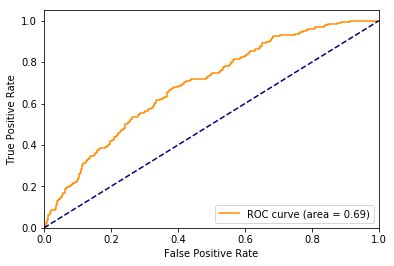

In [77]:
model=RandomForestClassifier(class_weight='balanced',n_estimators=500,max_leaf_nodes=50,criterion='entropy',max_depth=30,random_state=100) # RF
drawAUROC(model,'RF_exp_1.csv')

### Random Forest Tree calibration plots without normalzied

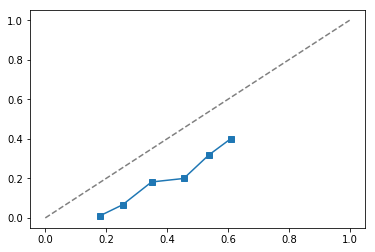

In [87]:
model=RandomForestClassifier(class_weight='balanced',n_estimators=500,max_leaf_nodes=50,criterion='entropy',max_depth=30,random_state=100) # RF
calibPlots(model,'RF_exp_1_cal.csv')

### Random Forest Tree calibration plots with normalzied

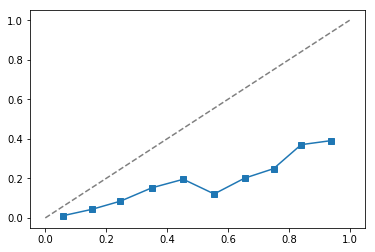

In [92]:
model=RandomForestClassifier(class_weight='balanced',n_estimators=500,max_leaf_nodes=50,criterion='entropy',max_depth=30,random_state=100)
calibPlots_normalized(model,'RF_exp_1_NorCal.csv')

# tuning hyperparameters for linearSVC based on "roc_auc"

In [41]:
parameters={'loss':('hinge','squared_hinge'),'C':[0.00001,0.0001,0.001,0.01,0.05,0.075]}
model = LinearSVC(class_weight='balanced',penalty='l2',random_state=100)
clf = GridSearchCV(model, parameters,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'loss': 'squared_hinge', 'C': 0.001}
             precision    recall  f1-score   support

          0       0.86      0.76      0.81      1229
          1       0.30      0.45      0.36       283

avg / total       0.75      0.70      0.72      1512



In [43]:
parameters={'C':[0.001,0.01,0.1,0.3,0.5,1,2]}
model = LinearSVC(class_weight='balanced',penalty='l1',loss='squared_hinge',dual=False,random_state=100)
clf = GridSearchCV(model, parameters,scoring='roc_auc',cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'C': 0.1}
             precision    recall  f1-score   support

          0       0.87      0.75      0.80      1229
          1       0.32      0.51      0.39       283

avg / total       0.77      0.70      0.73      1512



In [139]:
clf_model=LinearSVC(class_weight='balanced',penalty='l1',loss='squared_hinge',C=0.1,dual=False,random_state=100)
results=metrics_m_pre(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [113]:
results[0] ## this returns metrics with default threshold (0.5) for all metrics

,metrics,Score
0,AUROC,0.628298
1,F1,0.390773
2,accuracy,0.703042
3,precision,0.317181
4,recall,0.508834
5,specificity,0.747762


In [114]:
results[1]   ## this returns metrics with best F1 threshold, the AUROC is same as the above

,metrics,Score
0,F1,0.390773
1,accuracy,0.703042
2,precision,0.317181
3,recall,0.508834
4,specificity,0.747762


In [115]:
results[2]  ## this returns the threshold with best F1

0

In [88]:

# training set
Model = LinearSVC(class_weight='balanced',penalty='l1',loss='squared_hinge',C=0.1,dual=False,random_state=100).fit(X_train_transformed, y_train)
prediction=Model.predict(X_train_transformed)
# prediction_prob=Model.predict_proba(X_train_transformed)
# prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.6610974558212831

# tuning hyperparameters for Decision Tree based on "roc_auc"

In [44]:
parameters={'criterion':('gini','entropy'),'max_depth':[None,1,2,3,4,5,6,7,8,9,50,500,1000,5000], 'max_leaf_nodes':[None,2,3,5,6,7,8,9,10,100,200,300,500]}
model = DecisionTreeClassifier(class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters,scoring='roc_auc',cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')

print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'max_leaf_nodes': 6, 'criterion': 'gini', 'max_depth': None}
             precision    recall  f1-score   support

          0       0.88      0.58      0.70      1229
          1       0.27      0.66      0.38       283

avg / total       0.77      0.60      0.64      1512



In [116]:
clf_model=DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=6,criterion='gini',max_depth=None,random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [117]:
results[0]

,metrics,Score
0,AUROC,0.650591
1,F1,0.378433
2,accuracy,0.595899
3,precision,0.265714
4,recall,0.657244
5,specificity,0.581774


In [118]:
results[1]

,metrics,Score
0,F1,0.378433
1,accuracy,0.595899
2,precision,0.265714
3,recall,0.657244
4,specificity,0.581774


In [119]:
results[2]

0.3836530398595806

In [89]:

# training set
Model = DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=6,criterion='gini',max_depth=None,random_state=100).fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.69397881951278

### Decision Tree AUROC curve

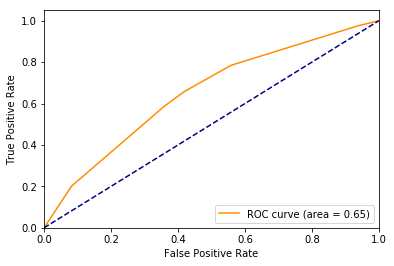

In [76]:
model=DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=6,criterion='gini',max_depth=None,random_state=100) # DT
drawAUROC(model,'DT_exp_1.csv')

### Deccision Tree calibration plots without normalzied

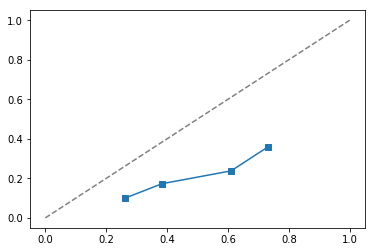

In [88]:
model=DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=6,criterion='gini',max_depth=None,random_state=100)
calibPlots(model,'DT_exp_1_cal.csv')

### Deccision Tree calibration plots with normalzied

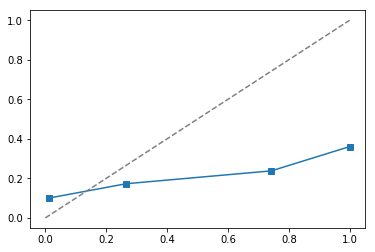

In [93]:
model=DecisionTreeClassifier(class_weight='balanced',max_leaf_nodes=6,criterion='gini',max_depth=None,random_state=100)
calibPlots_normalized(model,'DT_exp_1_NorCal.csv')

# tuning hyperparameters for SGD Classifier based on "roc_auc"

In [260]:
# import lightgbm as lgb

In [69]:
### SGBClassifier

parameters={'learning_rate':('constant','optimal','invscaling'),'eta0':(0.001,0.0001,0.00001),'loss':('hinge','log','modified_huber','huber','squared_loss','squared_hinge','perceptron','epsilon_insensitive','squared_epsilon_insensitive'),'penalty':('l2', 'l1', 'elasticnet'),'alpha':(0.0001,0.001,0.01,0.1)}
model = SGDClassifier(class_weight='balanced',random_state=100)
clf = GridSearchCV(model, parameters, n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'penalty': 'l2', 'alpha': 0.01, 'learning_rate': 'optimal', 'eta0': 0.001, 'loss': 'log'}
             precision    recall  f1-score   support

          0       0.85      0.83      0.84      1229
          1       0.32      0.35      0.34       283

avg / total       0.75      0.74      0.75      1512



In [120]:
clf_model=SGDClassifier(penalty='l2',class_weight='balanced',alpha=0.01,loss='log',learning_rate='optimal',eta0=0.001,random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [121]:
results[0]

,metrics,Score
0,AUROC,0.678514
1,F1,0.335043
2,accuracy,0.742725
3,precision,0.324503
4,recall,0.346290
5,specificity,0.834011


In [122]:
results[1]

,metrics,Score
0,F1,0.395274
1,accuracy,0.627646
2,precision,0.283951
3,recall,0.650177
4,specificity,0.622457


In [123]:
results[2]

0.393795540474873

In [124]:

# training set
Model = SGDClassifier(penalty='l2',class_weight='balanced',alpha=0.01,loss='log',learning_rate='optimal',eta0=0.001,random_state=100).fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.7077054535105816

# tuning hyperparameters for GrandientBoosting based on "roc_auc"

In [76]:
### 
parameters={'max_depth':range(5,16,2), 'min_samples_split':range(50,500,50),'learning_rate':(0.01,1e-05,0.1),'subsample':(0.1,0.2,0.3,0.5,0.8,0.9)}
model = GradientBoostingClassifier(random_state=100)
clf = GridSearchCV(model, parameters, n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

The parameters of the best model are: 
{'min_samples_split': 350, 'subsample': 0.3, 'learning_rate': 0.01, 'max_depth': 11}
             precision    recall  f1-score   support

          0       0.81      1.00      0.90      1229
          1       0.00      0.00      0.00       283

avg / total       0.66      0.81      0.73      1512



In [125]:
clf_model = GradientBoostingClassifier(min_samples_split=350,subsample=0.3,learning_rate=0.01,max_depth=11,random_state=100)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [126]:
results[0]

,metrics,Score
0,AUROC,0.681678
1,F1,0.000000
2,accuracy,0.812831
3,precision,0.000000
4,recall,0.000000
5,specificity,1.000000


In [127]:
results[1]

,metrics,Score
0,F1,0.411367
1,accuracy,0.712302
2,precision,0.333333
3,recall,0.537102
4,specificity,0.752644


In [128]:
results[2]

0.18469036042692943

In [129]:

# training set
Model = GradientBoostingClassifier(min_samples_split=350,subsample=0.3,learning_rate=0.01,max_depth=11,random_state=100).fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.770367069293202

### AUROC plots for GrandientBoostingClassifier (GDBT)

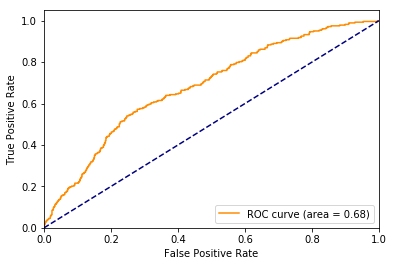

In [78]:
model=GradientBoostingClassifier(min_samples_split=350,subsample=0.3,learning_rate=0.01,max_depth=11,random_state=100) # RF
drawAUROC(model,'GDBT_exp_1.csv')

### GrandientBoostingClassifier (GDBT) calibration plots without normalzied

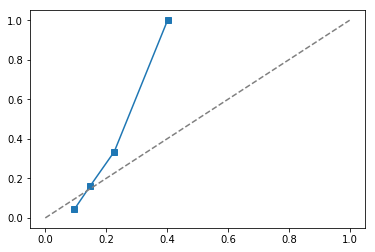

In [89]:
model=GradientBoostingClassifier(min_samples_split=350,subsample=0.3,learning_rate=0.01,max_depth=11,random_state=100)
calibPlots(model,'GDBT_exp_1_cal.csv')

### GrandientBoostingClassifier (GDBT) calibration plots with normalzied

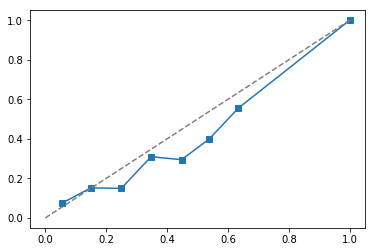

In [94]:
model=GradientBoostingClassifier(min_samples_split=350,subsample=0.3,learning_rate=0.01,max_depth=11,random_state=100)
calibPlots_normalized(model,'GDBT__exp_1_NorCal.csv')

# tuning hyperparameters for MultinomialNB based on "roc_auc"

In [81]:
from sklearn.naive_bayes import MultinomialNB

In [278]:

parameters={'fit_prior':[True,False],'alpha':[0.3,0.4,0.5,0.6,0.7,0.8,1,1.2,1.5]}
model = MultinomialNB()
clf = GridSearchCV(model, parameters,n_jobs=-1,scoring='roc_auc', cv=5)
clf.fit(X_train_transformed, y_train)
print('The parameters of the best model are: ')
print(clf.best_params_)
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred))


The parameters of the best model are: 
{'alpha': 0.3, 'fit_prior': True}
             precision    recall  f1-score   support

          0       0.83      0.90      0.86      1229
          1       0.31      0.18      0.23       283

avg / total       0.73      0.77      0.75      1512



In [130]:
clf_model = MultinomialNB(alpha=0.3,fit_prior=True)
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [131]:
results[0]

,metrics,Score
0,AUROC,0.652172
1,F1,0.230088
2,accuracy,0.769841
3,precision,0.307692
4,recall,0.183746
5,specificity,0.904801


In [132]:
results[1]

,metrics,Score
0,F1,0.378431
1,accuracy,0.580688
2,precision,0.261872
3,recall,0.681979
4,specificity,0.557364


In [133]:
results[2]

0.0729877973913016

In [97]:

# training set
Model =  MultinomialNB(alpha=0.3,fit_prior=True).fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.6802970214320403

# GaussianNB

In [134]:
clf_model=GaussianNB()
results=metrics_m_prob(clf_model,X_train_transformed,X_test_transformed,y_train,y_test)

In [135]:
results[0]

,metrics,Score
0,AUROC,0.665598
1,F1,0.344828
2,accuracy,0.346561
3,precision,0.212245
4,recall,0.918728
5,specificity,0.214809


In [136]:
results[1]

,metrics,Score
0,F1,0.390625
1,accuracy,0.587302
2,precision,0.269906
3,recall,0.706714
4,specificity,0.559805


In [137]:
results[2]

0.999319781217388

In [101]:

# training set
Model =  GaussianNB().fit(X_train_transformed, y_train)
# prediction=Model.predict(X_train_transformed)
prediction_prob=Model.predict_proba(X_train_transformed)
prediction_prob=prediction_prob[:,1]


fpr, tpr, tresholds = roc_curve(y_train, prediction_prob)
roc_auc = sklearn.metrics.auc(fpr,tpr) # get auroc score 
roc_auc

0.676881586455211